In [7]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMRegressor

from scipy.stats import entropy
from copy import deepcopy as copy

%matplotlib inline

# Класс дискретизации по принципу деления по медиане

In [8]:
# https://www.theanalysisfactor.com/continuous-and-categorical-variables-the-trouble-with-median-splits/

In [33]:
class MedianBinarizer(TransformerMixin):
    def __init__(self, n_bins: int):
        self.n_bins = n_bins
        self.x_bins = None
    
    def _get_feature_bins(self, X):
        #extra_bin = 0
        #if X.shape[0] % self.n_bins != 0:
        #    extra_bin = 1
        #    print('number of bins does not fit to dataset'
        #          ', extending number of bins to extra one')
        #
        #n_batch = X.shape[0] // self.n_bins
        #X_sorted = np.sort(X)
        #x_bins = [X[i*n_batch:(i+1)*n_batch] for i in range(self.n_bins + extra_bin)]
        
        iterations = np.log2(self.n_bins)
        if iterations - int(iterations) != 0:
            raise Exception('bins should be a power of 2')
        
        # получаем вариационный ряд
        x_bins = [np.sort(X)]
        for i in range(int(iterations)):
            new_bins = list()
            for j in x_bins:
                # середина среза вариационного ряда
                index = j.shape[0] // 2
                new_bins += [j[:index], j[index:]]
            x_bins = new_bins
        return x_bins
    
    def _lookup(self, x):
        for k, _bin in enumerate(self.x_bins):
            if x <= _bin[-1]:
                return k
        return k
    
    def _real_to_category(self, X):
        # X should not be a column vector
        X_new = []
        for x in X:
            i = self._lookup(x)
            
            if i != -1:
                X_new.append(i)
            else:
                raise Exception('something went wrong')

        return np.array(X_new).reshape(-1, 1)
    
    def fit(self, X):
        self.x_bins = self._get_feature_bins(X)
    
    def transform(self, X):
        encoder = OneHotEncoder()
        X_cat = self._real_to_category(X)

        return X_cat, encoder.fit_transform(X_cat)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [34]:
def synchronize_counts(_from: dict, _to: dict):
    subset = np.setdiff1d(list(_from.keys()), list(_to.keys()))
    for i in subset:
        _to[i] = 0

In [35]:
def cross_entropy(p, q):
    p = np.array(p)
    q = np.array(q)
    q[q == 0] = 0.0001
    return -np.sum(p * np.log(q))

# Дискретизированные переменные имеют равномерное распределение

In [36]:
binarizer = MedianBinarizer(32)

In [37]:
result = binarizer.fit_transform(np.random.normal(size=1000))[0]

In [ ]:
pd.Series(np.sort(np.random.normal(size=1000))).plot()

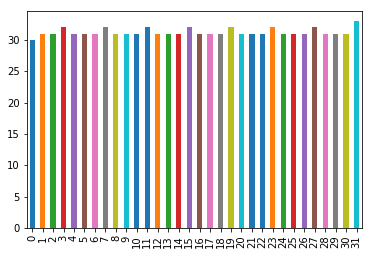

In [32]:
pd.Series(result.squeeze()).value_counts().sort_index().plot.bar()

In [155]:
X, y, coefs = make_regression(n_samples=2000, n_features=15, n_informative=4, n_targets=3, coef=True, random_state=42)
# introduce multicollinearity
X = np.concatenate([X, y], axis=1)

In [156]:
feature_space = []
for i in range(X.shape[1]):
    binarizer = MedianBinarizer(32)
    feature_space.append(binarizer.fit_transform(X[:, i].squeeze()))

In [158]:
test_classifiers = [
    LogisticRegression(random_state=42, multi_class='ovr'),
    LinearSVC(multi_class='ovr'),
    LGBMRegressor(boosting_type='rf')
]

In [169]:
np.random.seed(42)
initial_feature = np.random.randint(0, len(feature_space))

dataset_size = X.shape[0]
free_features = [i for i in range(len(feature_space)) if i != initial_feature]
subset = [initial_feature]

while len(subset) != len(feature_space):
    max_entropy = -1
    feature_index = -1
    
    stats = []
    
    
    for ix_feature, feature in enumerate(free_features):
        if len(subset) > 1:
            input_features = np.concatenate([feature_space[i][1].todense() for i in subset], axis=1)
        else:
            input_features = feature_space[subset[0]][1]
        
        clr = copy(test_classifiers[0])
        #train model on the given subset and new feature
        clr.fit(input_features, feature_space[feature][0].squeeze())
        #predict that feature with the given subset
        predicted = clr.predict(input_features)
        
        pred_category, pred_counts = np.unique(predicted, return_counts=True)
        real_category, real_counts = np.unique(feature_space[feature][0], return_counts=True)
        
        pred_proba = pred_counts / dataset_size
        real_proba = real_counts / dataset_size
        
        real_stats = dict(zip(real_category, real_proba))
        pred_stats =  dict(zip(pred_category, pred_proba))
        
        synchronize_counts(real_stats, pred_stats)
        
        ce_r_r = cross_entropy(list(real_stats.values()), list(real_stats.values()))
        ce_p_p = cross_entropy(list(pred_stats.values()), list(pred_stats.values()))
        ce_r_p = cross_entropy(list(real_stats.values()), list(pred_stats.values()))
        
        if max_entropy < ce_r_p:
            max_entropy = ce_r_p
            feature_index = ix_feature
        
        stats.append({'rr': ce_r_r, 'pp': ce_p_p, 'rp': ce_r_p})
    print('#'*100)
    print('subset', subset)
    print(pd.DataFrame(stats, index=free_features))
    print('#'*100)
    
    subset.append(free_features[feature_index])
    del free_features[feature_index]
    
print('generated ordered list of variables')
print(subset)
print('real informative variables')
print(np.unique(np.argwhere(coefs > 0)))

####################################################################################################
subset [6]
          pp        rp        rr
0   2.295987  6.185683  3.427511
1   2.518809  5.930758  3.427511
2   2.474590  6.069384  3.427511
3   2.337929  6.464581  3.427511
4   2.406044  6.011829  3.427511
5   2.469432  6.013683  3.427511
7   2.486111  5.995097  3.427511
8   2.210288  6.501541  3.427511
9   2.291224  6.208155  3.427511
10  2.257826  6.270207  3.427511
11  2.516209  5.983277  3.427511
12  2.351591  6.506372  3.427511
13  2.471983  5.991807  3.427511
14  2.514363  5.982797  3.427511
15  2.624434  5.584823  3.427511
16  2.411699  6.156048  3.427511
17  2.373485  6.394670  3.427511
####################################################################################################
####################################################################################################
subset [6, 12]
          pp        rp        rr
0   3.231030  3.929260  3.427511
1   3.07935